# Denoizing

Ressources:
- http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [357]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

from scipy import signal
import pywt

import helper_signal as hs

In [516]:
signals = hs.generate_signal()
# Signal before adding noise
y_clean = signals[2]
# Raw signal that we are trying to denoize.
y_raw = signals[3]
# Time vector.
t = signals[0]

 The goal is to get an estimate of y_clean with y_raw as input

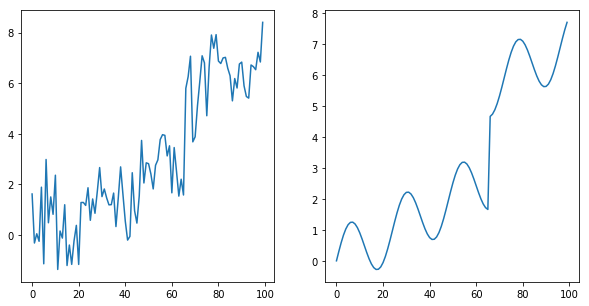

In [359]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(t_vec, y_raw)
ax[1].plot(t_vec, y_clean)

We can use
 - Moving average
 - Exponential Smoothing
 - Savitzky-Golay
 - Butterworth filter
 - Wavelet threshold
 
 Let's compare the cost and performance of these different methods.

## Simple Moving average

Probably the most basic method for denoizing a signal. 
As its name indicates, it averages the signal on a rolling window:

$$
y_{smooth}(t) = \frac{y(t - w) + y(t - w + 1) + ... + y(t)}{w}
$$

Where $w$ is the time window width.
It can be used real-time -by taking the current point as the end of the window.

Hyper parameters: $w$

In [360]:
def moving_average(y, window_w=10):
    """ Smooth signal 'y' with rolling window of width 'window_w'
    """
    # Average signal.
    y_smooth = []
    # Smoothing "real-time".
    for t in t_vec:
        if t < window_w:
            y_smooth.append(y[:t+1].mean())
        else:
            y_smooth.append(y[t-window_w:t].mean())
    return y_smooth

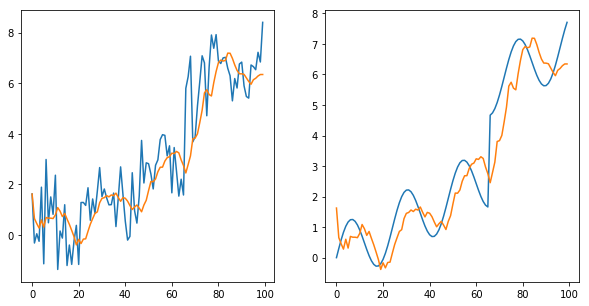

In [361]:
y_smooth = moving_average(y_raw, 8)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(t_vec, y_raw)
ax[0].plot(t_vec, y_smooth)
ax[1].plot(t_vec, y_clean)
ax[1].plot(t_vec, y_smooth)

We notice the delay of the smoothed signal caused by the moving average

## Exponential Smoothing 

Follow the formula 
$$ y_{smooth}(t) = \alpha * y(t) + (1 - \alpha) * y_{smooth}(t - 1)$$

Hyper parameters: $\alpha$

In [362]:
def exp_smooth(y, alpha=0.1):
    """
    """
    # Average signal.
    y_smooth = []
    # Smoothing "real-time".
    for t in t_vec:
        if t == 0:
            y_smooth.append(y[t])
        else:
            y_smooth.append(alpha * y[t] + (1 - alpha) * y_smooth[t-1])
    return y_smooth
    

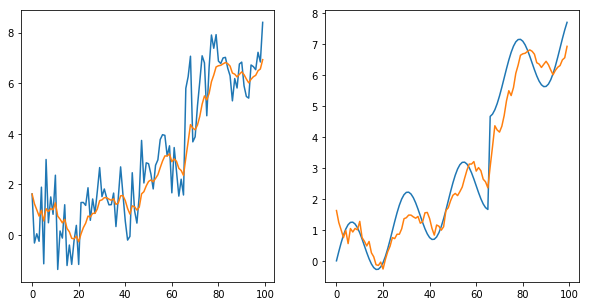

In [363]:
y_smooth = exp_smooth(y_raw, 0.2)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(t_vec, y_raw)
ax[0].plot(t_vec, y_smooth)
ax[1].plot(t_vec, y_clean)
ax[1].plot(t_vec, y_smooth)

There is still a delay, but it seems smaller

## Savitzky-Golay 

This filter is fitting successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares.

Hyper parameters:
- $w$: the window length.
- $p$: the order of the polynom to fit.

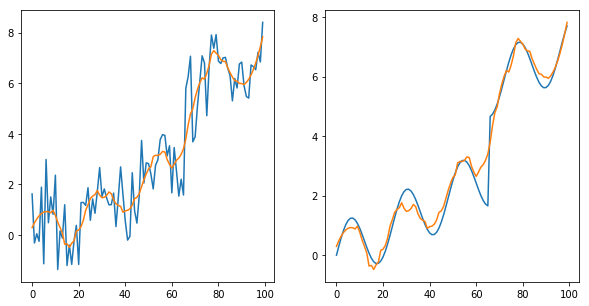

In [364]:
y_smooth = signal.savgol_filter(y_raw, window_length=17, polyorder=2)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(t_vec, y_raw)
ax[0].plot(t_vec, y_smooth)
ax[1].plot(t_vec, y_clean)
ax[1].plot(t_vec, y_smooth)

## Butterworth filter 

In [365]:
def pass_low_butter(y, sf, high_hz=0.1, order=5, deterministic=False):
    """Implement a butter pass_low filter.                                              
                                                                                   
    Args:                                                                          
        y (ndarray): the signal to be filtered.                               
        sf (uint32): the sampling frequency.                                                 
        high_hz (float): the higher bound of the filter in Hz (default 9000)       
        order (uint): order of the filter. (default 2)                             
                                                                                   
    Returns:                                                                       
        ndarray: the filtered signal                                               
    """
    # Nyquist frequency                                                            
    # (highest frequency of the original signal that is not aliased).              
    nyq = sf /2
    # Frequency in term of Nyquist multipliers.                                    
    high = high_hz / nyq
    # Calculate coefficients.                                                      
    b, a = signal.butter(order, high, btype='low')
    # Filtered signal.
    if deterministic:
        filtered_signal = signal.filtfilt(b, a, y)
    else:
        filtered_signal = signal.lfilter(b, a, y)
    return filtered_signal   

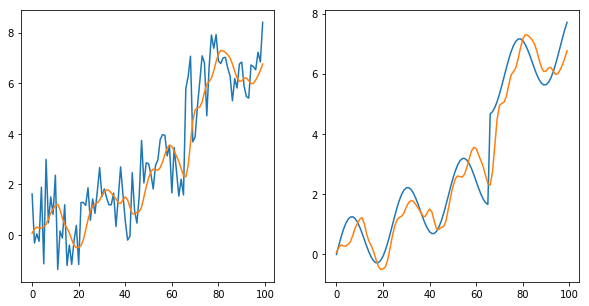

In [366]:
y_smooth = pass_low_butter(y_raw, 1, 0.08, 2)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(t_vec, y_raw)
ax[0].plot(t_vec, y_smooth)
ax[1].plot(t_vec, y_clean)
ax[1].plot(t_vec, y_smooth)

We can also use it in a non deterministic (not "real-time") fashion

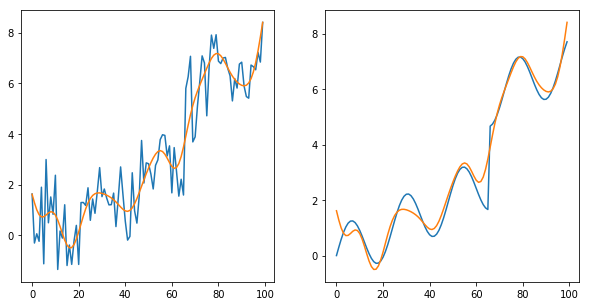

In [367]:
y_smooth = pass_low_butter(y_raw, 1, 0.08, 5, deterministic=True)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(t_vec, y_raw)
ax[0].plot(t_vec, y_smooth)
ax[1].plot(t_vec, y_clean)
ax[1].plot(t_vec, y_smooth)

# ADD FOURIER

In [1]:
x = np.arange(40)
y = np.log(x + 1) * np.exp(-x/8.) * x**2 + np.random.random(40) * 15
rft = np.fft.rfft(y)
rft[5:] = 0   # Note, rft.shape = 21
y_smooth = np.fft.irfft(rft)

plt.plot(x, y, label='Original')
plt.plot(x, y_smooth, label='Smoothed')
plt.legend(loc=0).draggable()
plt.show()

NameError: name 'np' is not defined

## Wavelet threshold

"The advantage of the DWT again comes from the many wavelet shapes there are available. You can choose a wavelet which will have a shape characteristic to the phenomena you expect to see. In this way, less of the phenomena you expect to see will be smoothed out".

This cannot be done in a non-deterministic way.

Hyper parameters:
- thresh
- wavelet type
- padding mode
- mode in threshold

In [491]:
def dw_filter(y, thresh = 0.63, wavelet="db4", padding="symmetric"):
    thresh = thresh*np.nanmax(y)
    # Getting the wavelet decomposition coefficients.
    coeff = pywt.wavedec(y, wavelet, mode=padding)
    # Thresholding the coefficients.
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode=padding)
    return reconstructed_signal

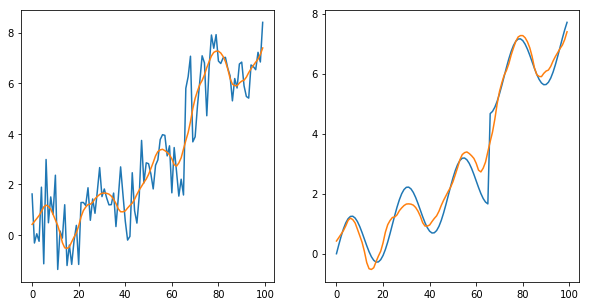

In [369]:
y_smooth = dw_filter(y_raw, .50)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(t_vec, y_raw)
ax[0].plot(t_vec, y_smooth)
ax[1].plot(t_vec, y_clean)
ax[1].plot(t_vec, y_smooth)